In [1]:
import os
# os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl

import jax.scipy as jsp
import matplotlib.pyplot as plt
import matplotlib as mpl
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
from jax import Array
import jax
from tqdm.notebook import tqdm
# import optimistix

# import ehtplot
import scienceplots
# import cmasher as cmr
# plt.style.use("science")

%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
# plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

ito_seven = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#E69F00", "#F0E442"]
contrast_three = ["#004488", "#BB5566", "#DDAA33"]

# Creating a jittered instrument
Using new class `dlT.JitteredToliman` 

In [2]:

# jax
import dLuxToliman as dlT
import dLux
from dLuxToliman import AlphaCen
import jax
from jax import numpy as np, Array
import jax.scipy as jsp

import zodiax as zdx
from zodiax import filter_vmap

from setup_jitter import AlphaCenMeanWavel

def setup_jitter(
    angle=0.,
    mag=0.5*0.375,
    shear=0.2,
    r=0.25e-4,
    oversample=4,
    norm_osamp=6,
    det_pscale=np.array(0.375),
    det_npixels=128,
    kernel_size=17,
    n_psfs=4,
    source=AlphaCen,
    prior_fn=lambda model: np.array(0.),
    ):

    lin_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'linear', "n_psfs": n_psfs}
    shm_params = {"jitter_mag": mag, "jitter_angle": angle, "jitter_shape": 'shm', "n_psfs": n_psfs}
    norm_params = {"r": r, "shear": shear, "phi": angle, "kernel_size": kernel_size}
    radial_orders = [2, 3]

    # Creating common optical system
    optics = dlT.TolimanOpticalSystem(
        oversample=oversample,
        psf_npixels=det_npixels,
        radial_orders=radial_orders,
        psf_pixel_scale=det_pscale,
        )

    optics = optics.divide('aperture.basis', 1e9) # Set basis units to nanometers
    norm_optics = optics.set("oversample", norm_osamp)

    # Creating common source
    src = source(
        separation=np.array(10.),
        position_angle=np.array(90.),
        x_position=np.array(0.),
        y_position=np.array(0.),
        log_flux=np.array(6.832),
        contrast=np.array(3.37),
    )

    # creating telescopes
    lin_det = dLux.LayeredDetector([('Downsample', dLux.Downsample(oversample))])
    shm_det = lin_det
    norm_det = dLux.LayeredDetector([
        ('Jitter', dlT.GaussianJitter(**norm_params)),
        ('Downsample', dLux.Downsample(norm_osamp)),
    ])

    lin_tel = dlT.JitteredToliman(source=src, optics=optics, **lin_params).set('detector', lin_det)
    shm_tel = dlT.JitteredToliman(source=src, optics=optics, **shm_params).set('detector', shm_det)
    norm_tel = dlT.Toliman(source=src, optics=norm_optics).set('detector', norm_det)

    # creating simulated data
    lin_data = lin_tel.jitter_model()
    shm_data = shm_tel.jitter_model()
    norm_data = norm_tel.model()
    # setting norm_tel to a reasonable oversample
    # norm_tel = norm_tel.set(['oversample', "Downsample.kernel_size"], 2*[oversample])

    # jitter_posterior_fn = lambda model, data: jsp.stats.poisson.logpmf(data, model.jitter_model()).sum() + prior_fn(model)
    def posterior_fn(model, data):
        likelihood = jsp.stats.poisson.logpmf(np.round(data), model.jitter_model()).sum()
        prior = prior_fn(model)
        # print(likelihood, prior)
        return likelihood + prior
    
    # model_fn = lambda model, data: jsp.stats.poisson.logpmf(data, model.model()).sum()
    norm_posterior_fn = lambda model, data: jsp.stats.poisson.logpmf(np.round(data), model.model()).sum() + prior_fn(model)
    
    calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, posterior_fn, data, shape_dict={'wavelengths': 1})
    norm_calc_cov = lambda model, data, parameters: zdx.covariance_matrix(model, parameters, norm_posterior_fn, data, shape_dict={'wavelengths': 1})

    models = {"lin": lin_tel, "shm": shm_tel, "norm": norm_tel}
    loglike_fns = {'lin': posterior_fn, 'shm': posterior_fn, "norm": norm_posterior_fn}
    datas = {
        'lin': lin_data,
        'shm': shm_data,
        "norm": norm_data,
        }

    common_params = [
        'separation',
        'position_angle',
        'x_position',
        'y_position',
        'log_flux',
        'contrast',
        'wavelengths',
        'psf_pixel_scale',  
    ]

    lin_params = [
        'jitter_mag',
        'jitter_angle',
        'aperture.coefficients',
    ]

    norm_params = [
        'Jitter.r',
        'Jitter.shear',
        'Jitter.phi',
        'aperture.coefficients',
    ]

    params = {
        "lin": common_params + lin_params,
        "shm": common_params + lin_params,
        "norm": common_params + norm_params,
    }

    cov_fns = {
        "lin": zdx.filter_jit(calc_cov),
        "shm": zdx.filter_jit(calc_cov),
        "norm": zdx.filter_jit(norm_calc_cov),
    }

    return models, datas, params, loglike_fns, cov_fns

In [4]:
# from setup_jitter import setup_jitter

true_eff_wavel = 585.  # nm
wavel_precision = 50  # nm

def wavel_prior(model, truth=true_eff_wavel, sigma=wavel_precision):
    """
    Prior on the mean wavelength of the model in nm.
    """
    return jsp.stats.norm.logpdf(model.mean_wavelength, truth, sigma)

def plate_scale_prior(model, truth=0.375, sigma=0.0000375):
    return jsp.stats.norm.logpdf(model.psf_pixel_scale, truth, sigma)

def prior_fn(model):
    return wavel_prior(model) + plate_scale_prior(model)

models, datas, params, loglike_fns, cov_fns = setup_jitter(
    oversample=4,
    # prior_fn=prior_fn,
    )

print(models['lin'].wavelengths.mean() == true_eff_wavel)


True


# Fisher Sweeping

In [5]:
def fisher_sweep(
        tel,
        data,
        cov_fn,
        params,
        mags=np.linspace(1e-4, 2 * 0.375, 10),
        angs=np.linspace(0, 90, 3),
    ):

    seps = []

    # looping over jitter magnitude
    for mag_idx, mag in tqdm(enumerate(mags), total=len(mags)):
        model = tel.set("jitter_mag", mag)

        # looping over jitter angle
        for ang_idx, ang in enumerate(angs):        
            model = model.set("jitter_angle", ang)

            # calculate covariance matrix
            cov = cov_fn(model, np.round(data), params)

            # read separation from covariance matrix
            sep = np.sqrt(np.abs(cov[0, 0]))
            seps.append(sep)

            # check for NaNs
            if np.isnan(sep).any():
                print(f"NaNs found at mag_idx={mag_idx}, ang_idx={ang_idx}")
                raise ValueError

    seps = np.array(seps).reshape(len(mags), len(angs))
    return seps

In [6]:
# Marginal parameters
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'jitter_mag',
    'jitter_angle',
    'aperture.coefficients',
    # 'wavelengths',
    # 'psf_pixel_scale',  
]

In [ ]:
def cov_to_corr(cov_matrix):

    # Compute standard deviations (sqrt of diagonal)
    std_devs = np.sqrt(np.diag(cov_matrix))

    # Outer product of std_devs gives the denominator for normalization
    denominator = np.outer(std_devs, std_devs)

    # Compute the correlation matrix
    correlation_matrix = cov_matrix / denominator

    return correlation_matrix

# # # # testing
tester = cov_fns["lin"](models["lin"], np.round(datas["lin"]), params)
# print(tester)

# np.save("tester.npy", tester)

correlation = cov_to_corr(tester)
plt.figure(figsize=(9, 6))
plt.imshow(
    correlation,
    origin='upper',
    cmap="seismic",
    norm=mpl.colors.CenteredNorm(),
    )
plt.colorbar(label="Correlation Coefficient")
for j, lab in enumerate(params):
    plt.scatter(j, j, label=lab)
plt.axis('off')
plt.title("Correlation Matrix")
plt.legend()
plt.show()



In [12]:
seps_lin = fisher_sweep(
    models["lin"],
    datas["lin"],
    cov_fns["lin"],
    params,
    # mags=np.linspace(1e-4, 2 * 0.375, 10)
    mags=np.linspace(0.5, 0.6, 6),
    angs=np.linspace(0, 45, 5),
    )


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
seps_shm = fisher_sweep(
    models["shm"], 
    datas["shm"], 
    cov_fns["shm"], 
    params,
    mags=np.linspace(1e-4, 2 * 0.375, 20),
    )


In [8]:
# np.save("files/seps/seps_lin_no.npy", seps_lin)
# np.save("files/seps/seps_shm_no.npy", seps_shm)
# np.save("files/seps/seps_lin_nowl.npy", seps_lin)
# np.save("files/seps/seps_shm_nowl.npy", seps_shm)

In [10]:
# seps_lin = np.load("files/seps/seps_lin.npy")
# seps_shm = np.load("files/seps/seps_shm.npy")
# seps_lin = np.load("files/seps/seps_lin_nowl.npy")
# seps_shm = np.load("files/seps/seps_shm_nowl.npy")

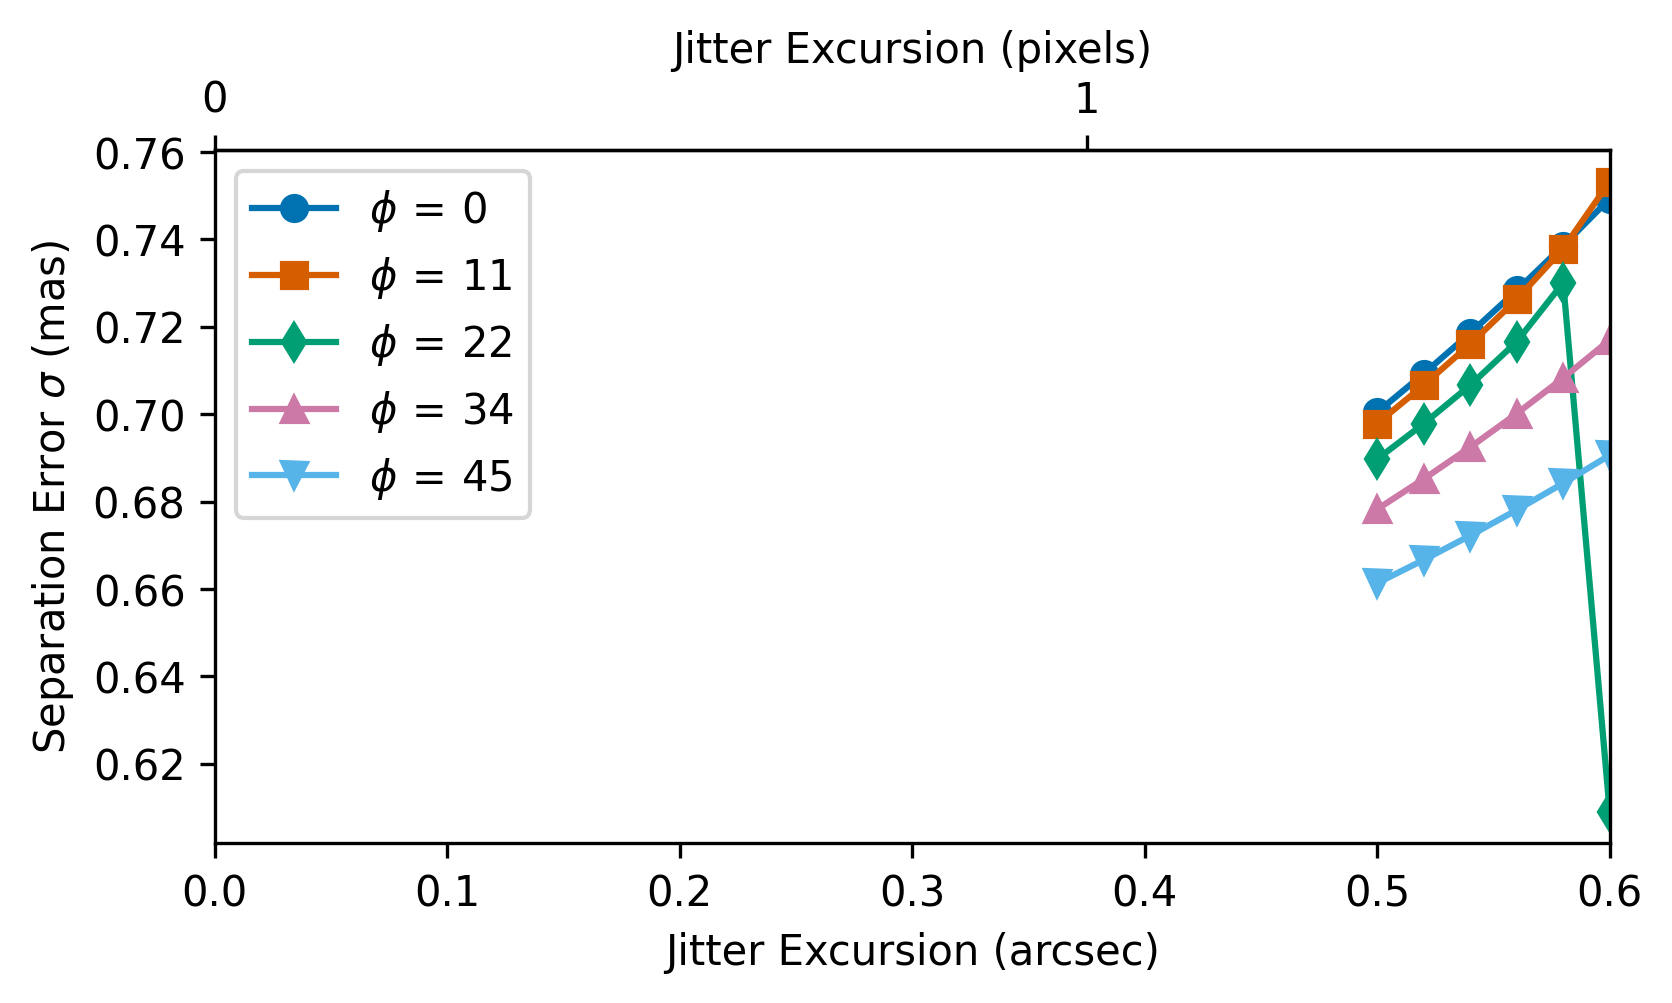

In [15]:
def plot_seps(
        seps,
        mags=np.linspace(1e-4, 2 * 0.375, 20),
        angs=np.linspace(0, 90, 3),
        baseline=2.5556666339644867,
        det_pscale=0.375,
        colors=None,
        ):
    fig, ax = plt.subplots(figsize=(6, 3))

    if colors is None:
        colors = [(0, 151/256, 54/256), (238/256, 42/256, 53/256), (192/256, 147/256, 0)]
    markers = ['o', 's', 'd', '^', 'v', '<', '>']

    for sep, ang, c, m in zip(seps.T, angs, colors, markers):
        ax.plot(mags, 1000 * sep, label=r"$\phi\,=\,$"+f"{ang:.0f}", color=c, marker=m)

    # baseline
    if baseline is not None:
        ax.axhline(baseline, linestyle='-.', c='k', label='No Jitter')

    ax.set(
        xlabel='Jitter Excursion (arcsec)',
        ylabel=r'Separation Error $\sigma$ (mas)',
        xlim=(0, mags.max()),
        # ylim=(None, 3.15),
        # title=f"Fisher Analysis of {title} Jitter",
    )

    # Add secondary x-axis scale showing units of pixels
    ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
    ax2.set(
        xlabel='Jitter Excursion (pixels)',
        xticks=[0, 1., 2.]
        )
    # ax.axvline(x=det_pscale, linestyle='-', color='k', alpha=0.3, linewidth=0.5)

    # ax.tick_params(direction='in')
    # ax2.tick_params(direction='in')
    ax.legend()
    # ax.grid(True, alpha=0.5, linestyle='--')

    # plt.savefig(f"figs/{title}_results.pdf", dpi=500, bbox_inches='tight')
    plt.show()

plot_seps(
    seps_lin,
    colors=ito_seven,
    baseline=None,
    mags=np.linspace(0.5, 0.6, 6),
    angs=np.linspace(0, 45, 5),
    )
# plot_seps(seps_shm, colors=contrast_three, baseline=None)

In [10]:
seps_lin

Array([[0.00069798, 0.00070044, 0.00069843, 0.00069196, 0.00068201],
       [0.00072014, 0.00072338, 0.00072163, 0.00071425, 0.00070127],
       [0.00074499, 0.00074934, 0.00075181, 0.00063712, 0.00072769]],      dtype=float64)

# Normal Model

In [6]:
def fwhm_to_det(fwhm, shear):
    return (1 - shear)**2 * (fwhm/2.35482)**4

def det_to_fwhm(det, shear):
    return 2.35482 * (det / (1 - shear)**2) ** 0.25

In [ ]:
# Marginal params
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    # 'wavelengths',
    'psf_pixel_scale',
    'Jitter.r',
    'Jitter.shear',
    'Jitter.phi',
    'aperture.coefficients',
]

det_pscale = models["norm"].psf_pixel_scale
oversample = models["norm"].oversample
kernel_size = models["norm"].Jitter.kernel_size
# Bar sizes
# fwhms = np.linspace(0.1, 3 * det_pscale, 5)

# cov_fns["norm"](models["norm"], np.round(datas["norm"]), params)


In [ ]:
phis = np.array([0, 45, 90])
shears = np.array([0, 0.3, 0.7])
rs = np.logspace(-5, np.log10(fwhm_to_det(1.01*det_pscale, shears[0])), 10)

seps = []
fwhms = []
kernels = []

for shear_idx, shear in enumerate(shears):
    model = models["norm"].set("detector.Jitter.shear", shear)

    for r_idx, r in tqdm(enumerate(rs), total=len(rs)):
        fwhm = det_to_fwhm(r, shear)
        fwhms.append(fwhm)
        model = model.set("detector.Jitter.r", r)

        for phi_idx, phi in enumerate(phis):        
            # skipping over different angles for shear = 0
            if shear_idx == 0 and phi_idx != 0:
                sep = np.nan
            else:
                model = model.set("detector.Jitter.phi", phi)
                cov = cov_fns["norm"](model, np.round(datas["norm"]), params)
                sep = np.sqrt(np.abs(cov[0, 0]))
                if phi_idx == 0:
                    if r == rs.max():
                        kernels.append(model.Jitter.generate_kernel(det_pscale/oversample))
                # plt.imshow(model.Jitter.generate_kernel(det_pscale))
                # plt.title(f"{shear}, {phi}, {r:.2e}, {fwhm}")
                # plt.show()
                
            # covs.append(cov)
            seps.append(sep)
            # print(sep)
        
seps = np.array(seps).reshape(len(shears), len(rs), len(phis))
fwhms = np.array(fwhms).reshape(len(shears), len(rs))

In [9]:
np.save("files/seps/seps_norm_nowl.npy", seps)

In [10]:
seps_norm = np.load("files/seps/seps_norm_nowl.npy")

In [ ]:
models["norm"]

In [ ]:
markers = ['o', 's', 'd']

for i, shear in enumerate(shears):

    fig, (ax, axe) = plt.subplots(1, 2, figsize=(9.5, 3))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 2))

    # colors = [(0, 151/256, 54/256), (238/256, 42/256, 53/256), 'k']#(192/256, 147/256, 0)]

    for sep, phi, c, m in zip(seps[i].T, phis, ito_seven, markers):
        if shear == 0:
            label = None
        else:
            label = label=r"$\phi\,=$" +f" {phi:.0f}"
        ax.plot(rs, 1000 * sep, label=label, color=c, marker=m, alpha=0.8)
    ax.set(
        # title=shear,
        xlabel=r'det$\,\Sigma$',
        ylabel=r'Separation Error $\sigma$ (mas)',
        xlim=(0, rs.max()),
    )
    ax2 = ax.secondary_xaxis('top', functions=(lambda r: det_to_fwhm(r, shear), lambda fwhm: fwhm_to_det(fwhm, shear)))
    # ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
    ax2.set(
        xlabel='FWHM of semi-major axis (arcseconds)',
        xticks=np.round(2*np.linspace(0, 1, 5)**.25 * det_to_fwhm(rs.max(), shear), 1)/2,
        )
    # ax.axvline(x=fwhm_to_det(det_pscale, shear), linestyle=(0, (3, 1, 1, 1, 1, 1)), color=(192/256, 147/256, 0), alpha=1, linewidth=1, label='1 Pix')

    ax.text(0.61, 0.95, f"Shear: {shear}", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    # ax.axhline(2.5556666339644867, linestyle='-.', c='k')
    ax.text(0.01, 0.06, 'NO JITTER', transform=ax.transAxes, font='monospace', size=7, style='oblique')

    ax.tick_params(direction='in')
    # ax2.tick_params(direction='in')
    ax.legend(
        # loc='lower right',
        )
    # ax.grid(True, alpha=0.5, linestyle='--')

    extent = np.array([-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2]) * det_pscale / oversample
    c=axe.imshow(
        kernels[i],
        cmap='YlGnBu_r',
        origin='lower',
        extent=extent,
        )
    axe.set(
        # title='Convolution Kernel',
        xlabel='x (arcsec)',
        ylabel='y (arcsec)',
        xticks=np.linspace(-0.2, 0.2, 3),
        yticks=np.linspace(-0.2, 0.2, 3),
    )
    max_fwhm = det_to_fwhm(rs.max(), shear)
    # axe.text(1.5, 0.95, f"FWHM: {max_fwhm:.2f}as", transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    axe.hlines(0, -max_fwhm/2, max_fwhm/2, colors='violet', linestyles='solid', label='FWHM', linewidth=3)
    fig.colorbar(c, ax=axe, label='Kernel Value')
    axe.legend(labelcolor='white')
    # plt.savefig(f'figs/gaussian_jitter_{shear}.pdf', bbox_inches='tight')
    plt.show()


# Model Cross-Fitting

In [6]:
def run_grad_desc(
        model,
        data,
        params,
        optimisers: dict,
        loss_func,
        iters=100,
        plot=False,
        verbose=True,
        eps=3e-4, # termination condition
        ):
    """
    Run gradient descent on a model.
    """

    # run gradient descent
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)
    losses, models_out = [], []

    if verbose:
        t = tqdm(range(iters), desc='Gradient Descent')
    else:
        t = range(iters)
        
    for i in t: 

        # for termination condition
        last_params = model.get(params)

        loss, grads = loss_func(model, np.round(data))

        # print(grads)

        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        models_out.append(model)
        losses.append(loss)

        # if np.isnan(np.array(grads.get(params))).sum() != 0:
        #     raise ValueError("NaN gradient")
        # if np.isneginf(np.array(grads.get(params))).sum() != 0:
        #     raise ValueError("Neginf gradient")
        
        if verbose:
            t.set_description("Loss: {:.6e}".format(loss)) # update the progress bar

        # Terminating condition
        new_params = model.get(params)  # getting new parameters
        scaled_diffs = jax.tree.map(  
            lambda x, y: np.abs((x - y)/y),
            last_params,
            new_params,
            )
        if np.all(np.array(  # if all parameters have converged
            jax.tree.map(lambda x: np.all(x < eps), scaled_diffs)
            )):
            print("Converged early")
            break

    if plot:
        plt.figure()
        plt.title("Log Poisson Loss")
        plt.xlabel("Epoch")
        plt.plot(range(i+1), losses)
        plt.show()

        plt.figure()
        for param in params:
            param_out = np.array([m.get(param) for m in models_out])
            if param_out.size//iters > 1:
                plt.plot(range(i+1), param_out - param_out[0], label=param)
            else:
                plt.plot(range(i+1), param_out, label=param)
            plt.xlabel("Epoch")
            plt.legend()
            plt.ticklabel_format(style='plain', axis='both', useOffset=False)
            plt.show()


    return models_out[-1]

In [7]:
# from setup_jitter import setup_jitter
import optax

models, datas, params, loglike_fns, cov_fns = setup_jitter(
    source=AlphaCenMeanWavel,
    prior_fn=prior_fn,
)

def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)


base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

In [ ]:
import random
from datetime import datetime
from jax import random as jr

sep_dict = {}
n_realisations = 1

# Gradient descent
common_optimisers = {
    "separation": sgd(5e-8, 0),
    'position_angle': sgd(2e-6, 3),
    'x_position': sgd(1.5e-8, 0),
    'y_position': sgd(1.5e-8, 2),
    'log_flux': sgd(1e-8, 0),
    'contrast': sgd(6e-6, 1),
    # 'mean_wavelength': sgd(8e-4, 20),
    'psf_pixel_scale': sgd(3e-11, 0),
    'aperture.coefficients': sgd(1e-3, 0),
}
    # 'mean_wavelength': adam(1e-2, 20),
    # 'psf_pixel_scale': adam(1e-5, 0),

lin_opts = {
    "jitter_mag": sgd(1.5e-6, 0),
    "jitter_angle": sgd(3e-1, 0),
}

norm_opts = {
    "Jitter.r": sgd(5e-14, 0),
    "Jitter.shear": sgd(4e-5, 0),
    "Jitter.phi": sgd(1e0, 0),
}


for model_key in tqdm(models.keys(), desc="Models"):

    # if model_key != "norm":
    #     continue

    if model_key == "norm":
        optimisers = {**common_optimisers, **norm_opts}
    else:
        optimisers = {**common_optimisers, **lin_opts}

    model = models[model_key]
    loglike_fn = loglike_fns[model_key]

    @zdx.filter_jit
    @zdx.filter_value_and_grad(list(optimisers.keys()))
    def loss_func(model, data):
        return -loglike_fn(model, data)
        # # model_array = model.jitter_model()
        # # return -np.nansum(jsp.stats.poisson.logpmf(data, model_array))
        # # return -loglike_fns[model.jitter_shape](model, data)
        # prior = prior_fn(model)
        # likelihood = np.nansum(jsp.stats.poisson.logpmf(np.round(data), model.jitter_model()))
        # return -(likelihood + prior)

    for data_key in tqdm(datas.keys(), desc='Data Arrays'):
        data = datas[data_key]
        sep_values = np.array([], dtype=np.float64)

        # if data_key != "norm":
        #     continue
        
        for i in tqdm(range(n_realisations), desc='Noise Realisations'):

            noisy_data = jr.poisson(
                jr.PRNGKey(random.randint(0, int(1e8))), 
                data,
                )

            gd_model = run_grad_desc(
                model,
                noisy_data,
                list(optimisers.keys()),
                optimisers=list(optimisers.values()),
                iters=100,
                loss_func=loss_func,
                plot=True,
                verbose=True,
                # eps=3e-4,
                eps=1e-6,
            )

            # raise ValueError("Stop here")

            sep_values = np.append(sep_values, gd_model.separation)

        sep_dict[f"{model_key}_{data_key}"] = sep_values

current_time = datetime.now().strftime('%d-%m-%Y_%H-%M')
save_str = current_time + f"_{n_realisations:04d}.npy"

# np.save(os.path.join(sep_dict_save_dir, save_str), sep_dict)

In [ ]:
loglike_fns["lin"](models["lin"], np.round(datas["lin"]))